# Projet Data Camp

This project can be found at "./datacamp.pdf". The aim is to find a way to maximize the "cells" size eaten at specific location within a limited range of time.

## Preprocessing

In this section, we will import, open data and manage to explore and maybe reorganize them.

### Imports

In [25]:
# Datascience libraries
import pandas as pd
import numpy as np

# basic python libraries
import math
import time
import random
import json
from tqdm.notebook import tqdm as pb

# plot
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

# local imports
from classes.Game import *
from classes.Strategy import *
from classes.Metrics import *
import seaborn as sns

### Opening Data

In [5]:
#Parser de fichiers
df = pd.read_csv("data.txt",header=None)
df.head()

,0,1,2,3
0,0,-11.03,-82.33,46
1,1,-4.93,-98.05,96
2,2,81.52,2.41,49
3,3,36.82,-42.62,71
4,4,-69.86,11.88,27


### Exploring Data

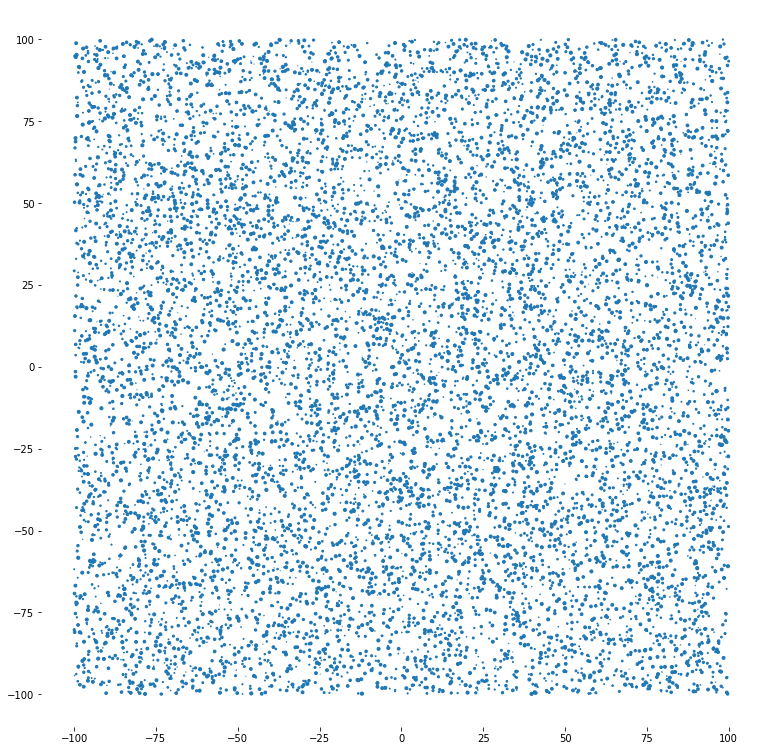

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
scat = ax.scatter(df.iloc[:,1], df.iloc[:,2],s=0.1*df.iloc[:,3])

--> distributed in a uniform way

## CSV Writter And Checker

In [7]:
def check_length_and_correctness(ids):
    print(len(ids))
    check_df = pd.DataFrame(ids)
    check_df = check_df[0].value_counts().values
    print("{}".format("correct" if len(check_df[check_df > 1]) == 0 else "some keys are present more than one time"))

In [8]:
def parser(ids, name):
    df = pd.DataFrame(ids)
    df.to_csv('{}.csv'.format(name), header=False, index=False)

In [9]:
def LoadGraph(neightbors):
    with open('{}neightbors_matrix.json'.format(neightbors)) as json_file:
        return np.array(json.load(json_file))

In [10]:
def scatter_eaten(df, result):
    eatenP = {"eaten":'r',"alive":'b'}
    eaten = result[0]
    hue = []
    for id in df.loc[:,0]:
        if id in eaten:
            hue.append("eaten")
        else :
            hue.append("alive")

    fig = plt.figure()
    sns.scatterplot(x=df.iloc[:,1],y=df.iloc[:,2],s=0.5*df.iloc[:,3],
                    hue = hue, palette = eatenP)

## Applying Strategies

### Naives approach

In [15]:
M2 = LoadGraph(1000)
M = df.values
_max_time = 10_000.
_init_pos = (0,0)

#### Euclidean 1

In [79]:
strategy = Naive_Metric_Strategy(Euclidean_1_Metric())
result = play_game(Game(_max_time, np.copy(M2)), np.copy(M), strategy, _init_pos)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 10045.28739427806
Score :
   > 331673.0


In [80]:
check_length_and_correctness(result[0])

6059
correct


In [81]:
parser(result[0], "Euclidean_1_Metric")

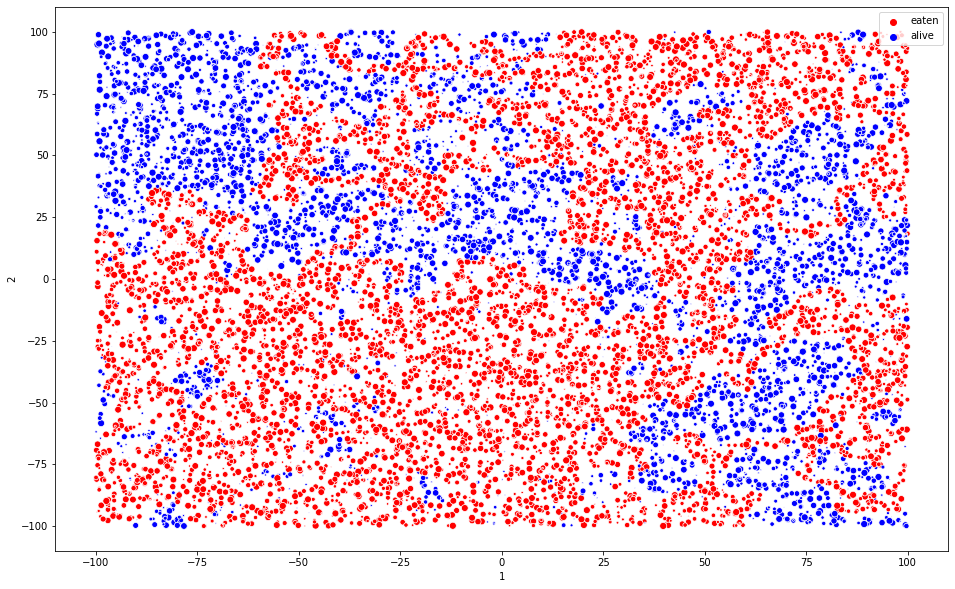

In [82]:
scatter_eaten(df, result)

#### Euclidean 2

In [83]:
strategy = Naive_Metric_Strategy(Euclidean_2_Metric())
result = play_game(Game(_max_time, np.copy(M2)), np.copy(M), strategy, _init_pos)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 10035.848168356039
Score :
   > 331900.0


In [84]:
check_length_and_correctness(result[0])

6117
correct


In [85]:
parser(result[0], "Euclidean_2_Metric")

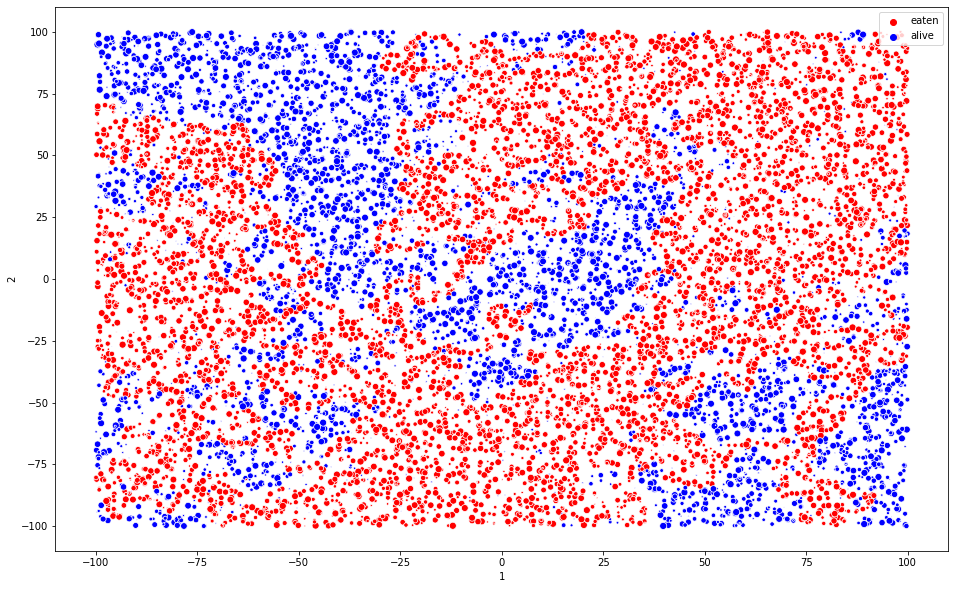

In [86]:
scatter_eaten(df, result)

#### Euclidean 3

In [87]:
strategy = Naive_Metric_Strategy(Euclidean_3_Metric())
result = play_game(Game(_max_time, np.copy(M2)), np.copy(M), strategy, _init_pos)
print("Score :\n   > {}".format(result[1]))

Time consumed :
   > 10034.402884042423
Score :
   > 332466.0


In [88]:
check_length_and_correctness(result[0])

5676
some keys are present more than one time


In [89]:
parser(result[0], "Euclidean_3_Metric")

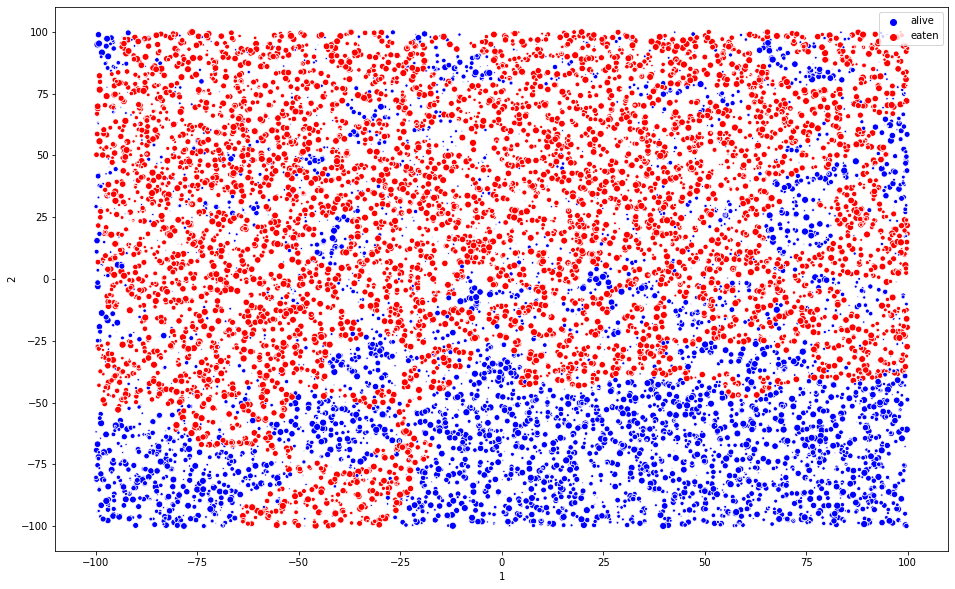

In [90]:
scatter_eaten(df, result)

## Seing next step environnement

In [11]:
class Game2(object):
    
    def __init__(self, time, neigtbors, m, n):
        super(Game2, self).__init__()
        self._const_time = time
        self.neigtbors = neigtbors
        self.n = n
        self.m = m
    
    # init a game and reset it
    def init_game(self, M, init_coord):
        self._Values = M[:,1:]
        self._Ids = M[:, 0].astype(int)
        self.actual_coord = (init_coord[0], init_coord[1], -1)
        self.ids = []
        self.rewards = []
        self.time = 0.
        # first step
        possibilities = self.neigtbors[self.actual_coord[2]].tolist()
        rewards = []
        new_possibilities = []
        counter = 0
        for i in range(len(possibilities)):
            if counter == self.m:
                break
            id_ = int(possibilities[i][0])
            reward = self._Values[id_, 2]
            if reward != 0.:
                children = self.neigtbors[id_]
                c_rewards = [self._Values[int(children[j][0]), 2] for j in range(self.n)]
                rewards.append(
                    (
                        reward,
                        sum([c_rewards[j] / children[j][1]**3  if children[j][1] != 0. and c_rewards[j] != 0. else 0. for j in range(self.n)])/self.n
                    )
                )
                new_possibilities.append(possibilities[i])
                counter+=1
        return False, False, new_possibilities, rewards, self._const_time - self.time, self.actual_coord
        
    # step in a game
    def step_env(self, action, distance):
        # check if there is a correct action or not
        if action == -1:
            return True, False, None, None, self._const_time - self.time, None
        else:
            # get reward
            reward = self._Values[action, 2]
            self._Values[action, 2] = 0.

            # keep track of action
            self.ids.append(self._Ids[action])
            self.rewards.append(reward)

            # update time and coordinate
            self.time += distance
            self.actual_coord = (self._Values[action, 0], self._Values[action, 1], action)

            # step into the environnement
            if self.time < self._const_time:
                possibilities = self.neigtbors[self.actual_coord[2]].tolist()
                rewards = []
                counter = 0
                new_possibilities = []
                for i in range(len(possibilities)):
                    if counter == self.m:
                        break
                    id_ = int(possibilities[i][0])
                    reward = self._Values[id_, 2]
                    if reward != 0.:
                        children = self.neigtbors[id_]
                        c_rewards = [self._Values[int(children[j][0]), 2] for j in range(self.n)]
                        rewards.append(
                            (
                                reward,
                                sum([c_rewards[j] / children[j][1]**3  if children[j][1] != 0. and c_rewards[j] != 0. else 0. for j in range(self.n)])/self.n
                            )
                        )
                        new_possibilities.append(possibilities[i])
                        counter+=1
                return False, False, new_possibilities, rewards, self._const_time - self.time, self.actual_coord
            else:
                # previous time was not correctly endled by the agent(strategy)
                return False, True, None, None, self._const_time - self.time, None
    
        
    
    # string representation of the object
    def __repr__(self):
        return "<Object : Game (DataCamp) <> time:{}>".format(self._const_time)
    def __str__(self):
        return self.__repr__()

In [12]:
class OneStep_Metric_Strategy(Strategy):
    
    def __init__(self, metric):
        super(OneStep_Metric_Strategy, self).__init__()
        self.metric = metric
        
    def choose_action(self, possibilities, rewards, time_left, coordinate):
        distances = [possibilities[i][1] for i in range(len(possibilities))]
        ids = [possibilities[i][0] for i in range(len(possibilities))]
        ratios = self.metric.apply(distances, rewards)
        action = self.metric.choose(distances, ids, ratios, time_left)
        return int(ids[action]), distances[action]
        
    # string representation of the object
    def __repr__(self):
        return "<Object : Strategy (DataCamp) <> OneStep_Metric_Strategy>"
    def __str__(self):
        return self.__repr__()

In [13]:
class OneStep_Euclidean_1_Metric(Metric):
    def __init__(self, ratio):
        super(OneStep_Euclidean_1_Metric, self).__init__()
        self.ratio = ratio
        
    def apply(self, distances, rewards):
        n = len(distances)
        euclidean_ratios = np.array([ ((rewards[i][0] / distances[i]**3 )*(self.ratio) + rewards[i][1]*(1-self.ratio))
                                       if distances[i] != 0. and rewards[i][0] != 0. else 0. for i in range(n)])
        mini = np.min(euclidean_ratios)
        if mini < 0.:
            for i in range(n):
                if euclidean_ratios[i] != 0.:
                    euclidean_ratios[i] -= (mini - 1)
        return euclidean_ratios

In [16]:
strategy = OneStep_Metric_Strategy(OneStep_Euclidean_1_Metric(0.50))
result = play_game(Game2(_max_time, np.copy(M2), 10, 10), np.copy(M), strategy, _init_pos)
print("Score :\n   > {}".format(result[1]))

Score :
   > 274189.0


In [17]:
check_length_and_correctness(result[0])

4982
correct


In [18]:
parser(result[0], "OneStep_Euclidean_1_Metric")

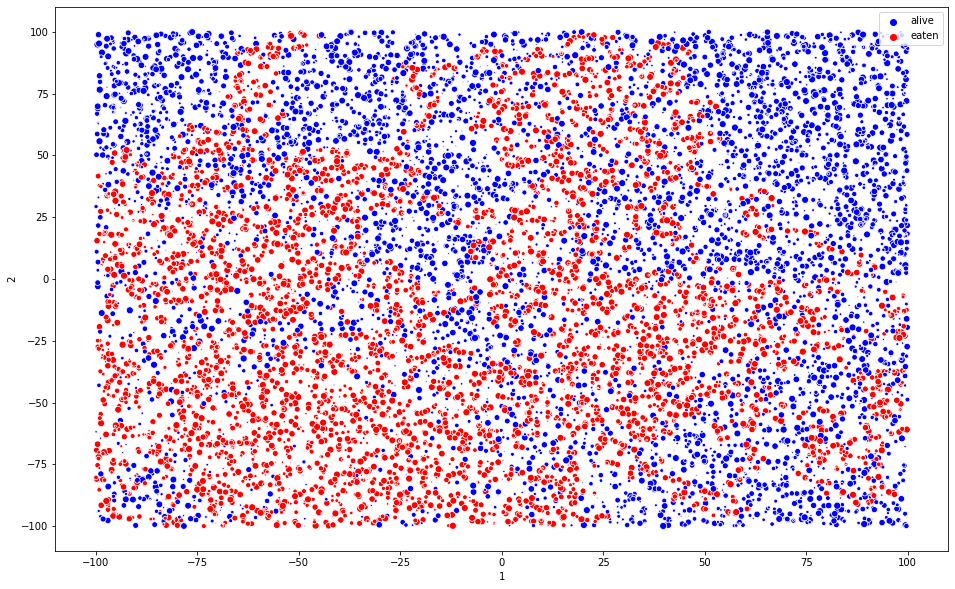

In [19]:
scatter_eaten(df, result)

In [28]:
def find_best_params(params, game_, M, strategy, init_coord):
    best_params = [0,0,0]
    best_res = [0,0]
    for m in pb(range(len(params["m"]))):
        for n in pb(range(len(params["n"]))):
            for ratio in pb(range(len(params["ratio"]))):
                strategy = OneStep_Metric_Strategy(OneStep_Euclidean_1_Metric(params["ratio"][ratio]))
                result = play_game(Game2(_max_time, np.copy(M2), params["m"][m], params["n"][n]), np.copy(M), strategy, _init_pos)
                if best_res[1] < result[1]:
                    best_params = [params["m"][m],params["n"][n],params["ratio"][ratio]]
                    best_res = result
    return best_params, best_res

In [29]:
params = {"m":[5,10,15,20,25], "n":[10,20,30,40,50,100,200], "ratio":[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]}
strategy = OneStep_Metric_Strategy(OneStep_Euclidean_1_Metric(0.50))
params, result = find_best_params(params, Game2(_max_time, np.copy(M2), 10, 10), np.copy(M), strategy, _init_pos)

In [30]:
params

[5, 40, 0.8]

In [31]:
result[1]

336412.0

In [38]:
params = {"m":[5,6,7], "n":[38,39,40,41,42,43], "ratio":[0.79,0.80,0.81]}
strategy = OneStep_Metric_Strategy(OneStep_Euclidean_1_Metric(0.50))
params, result = find_best_params(params, Game2(_max_time, np.copy(M2), 10, 10), np.copy(M), strategy, _init_pos)

In [39]:
params

[6, 38, 0.81]

In [40]:
result[1]

336736.0